In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# Thư viện xử lý mất cân bằng dữ liệu
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('2022/heart_disease_data.csv')

## Handling outlier

In [37]:
# Min-Max Outlier Capping for numeric variables
numeric_vars_to_cap = ['MentalHealthDays','SleepHours','BMI']

print("Min-Max Outlier Capping")
print("=" * 60)

# Ở trên t thấy có tính outlier, nên viết function để xuống đây gọi luôn cho dễ
for var in numeric_vars_to_cap:
    # Calculate IQR for outlier detection
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds (1.5*IQR method)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_low = (df[var] < lower_bound).sum()
    outliers_high = (df[var] > upper_bound).sum()
    total_outliers = outliers_low + outliers_high
    
    print(f"\n{var}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers before: {total_outliers} ({total_outliers/len(df)*100:.2f}%)")
    print(f"    - Below lower bound: {outliers_low}")
    print(f"    - Above upper bound: {outliers_high}")
    
    # Apply capping
    df[var] = df[var].clip(lower=lower_bound, upper=upper_bound)
    
    print(f"  Range after capping: [{df[var].min():.2f}, {df[var].max():.2f}]")

print("\n" + "=" * 60)
print("Outlier capping completed!")

Min-Max Outlier Capping

MentalHealthDays:
  Q1: 0.00, Q3: 5.00, IQR: 5.00
  Bounds: [-7.50, 12.50]
  Outliers before: 62076 (13.95%)
    - Below lower bound: 0
    - Above upper bound: 62076
  Range after capping: [0.00, 12.50]

SleepHours:
  Q1: 6.00, Q3: 8.00, IQR: 2.00
  Bounds: [3.00, 11.00]
  Outliers before: 7273 (1.63%)
    - Below lower bound: 2704
    - Above upper bound: 4569
  Range after capping: [3.00, 11.00]

BMI:
  Q1: 24.41, Q3: 31.09, IQR: 6.68
  Bounds: [14.39, 41.11]
  Outliers before: 18826 (4.23%)
    - Below lower bound: 425
    - Above upper bound: 18401
  Range after capping: [14.39, 41.11]

Outlier capping completed!


### **Question 1: The Compounding Effect of Multimorbidity**

**1. The Question**  
> *"How does the risk of Heart Attack (HadHeartAttack) change as an individual suffers from multiple chronic conditions simultaneously (Diabetes, Kidney Disease, COPD, Asthma, etc.)? Is this disease burden more impactful in younger age groups (lower AgeCategory) compared to older ones?"*

**2. Motivation & Benefits**
* **Motivation:** Most studies examine chronic diseases individually. However, in real-world settings, patients often suffer from multiple conditions at the same time. Quantifying the overall “disease burden” provides deeper insight into cumulative health deterioration.
* **Benefits:** Helps clinicians prioritize resources for patients with the most dangerous disease combinations, especially among younger individuals—where cardiovascular risk is often underestimated.
* **Stakeholders:** General practitioners, Preventive medicine specialists.

**3. Data Analysis Plan**
* **A. Preprocessing:**
  * Create a new numerical variable `Comorbidity_Score`: the total number of chronic diseases per individual (summing `HadDiabetes`, `HadKidneyDisease`, `HadArthritis`, `HadCOPD`, `HadAsthma`, `HadDepressiveDisorder` after binary encoding 0/1).
  * Encode `AgeCategory` into an ordinal numeric format for trend visualization.
* **B. Analysis:**
  * Use Pivot Tables or GroupBy to calculate the percentage of `HadHeartAttack` for each `Comorbidity_Score` level (0 diseases, 1 disease, 2 diseases, 3+ diseases).
  * Perform stratified analysis by `AgeCategory` to examine differences in risk gradients.
* **C. Visualization:**
  * **Grouped Bar Chart:** X-axis = `AgeCategory`, Y-axis = Heart Attack rate, color-coded bars represent different `Comorbidity_Score` levels.

In [ ]:
columns_analysis = ['HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
                'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'HadAngina', 'HadStroke']
target_column = 'HadHeartAttack'
categorical = ['AgeCategory']

df_q1 = df[columns_analysis + [target_column] + categorical].copy()

# Binary encoding: convert 'Yes'/'No' to 1/0
for col in columns_analysis + [target_column]:
    df_q1[col] = (df_q1[col] == 'Yes').astype(int)

# Calculate comorbidity score
df_q1['Comorbidity_Score'] = df_q1[columns_analysis].sum(axis=1)
# Group by hadHeartAttack and Comrbidity_Score
heart_attack_cases = df_q1[df_q1['HadHeartAttack']== 1]
#Get total rows
total_records = heart_attack_cases.shape[0]


In [ ]:
score_stats = heart_attack_cases.groupby('Comorbidity_Score', observed=False)['HadHeartAttack'].count().reset_index()
score_stats['Percentage_of_Total'] = (score_stats['HadHeartAttack'] / total_records) * 100
score_stats

In [ ]:
# Visualize by pie chart
labels = score_stats['Comorbidity_Score']
sizes = score_stats['Percentage_of_Total']

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8
)

plt.title('Distribution of Heart Attack Cases by Comorbidity Score')
plt.axis('equal')  # makes the pie a circle
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, sizes)

plt.xlabel('Comorbidity Score')
plt.ylabel('Percentage of Total (%)')
plt.title('Distribution of Heart Attack Cases by Comorbidity Score')

plt.xticks(labels)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

In [ ]:
# Analyze by AgeCategoryummary_stats
age_group_stats = heart_attack_cases.groupby(['AgeCategory', 'Comorbidity_Score'], observed=False)['HadHeartAttack'].count().reset_index()
age_group_totals = heart_attack_cases.groupby('AgeCategory', observed=False)['HadHeartAttack'].count().reset_index()
age_group_summary = pd.merge(age_group_stats, age_group_totals, on='AgeCategory', suffixes=('_Count', '_Total'))
age_group_summary['Percentage_of_Total'] = (age_group_summary['HadHeartAttack_Count'] / age_group_summary['HadHeartAttack_Total']) * 100
age_group_summary

pivot_table = age_group_summary.pivot(index='Comorbidity_Score', columns='AgeCategory', values='Percentage_of_Total').fillna(0)

In [ ]:
plt.figure(figsize=(12, 7))

for age in pivot_table.index:
    plt.plot(
        pivot_table.columns,
        pivot_table.loc[age],
        marker='o',
        linewidth=2,
        label=age
    )

plt.xlabel('Comorbidity Score')
plt.ylabel('Percentage within Age Group (%)')
plt.title('Comorbidity Score Distribution by Age Category', fontsize=14, weight='bold')

plt.xticks(range(10))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Age Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Number of age groups
age_categories = pivot_table.index.tolist()
n = len(age_categories)

# Grid size (auto)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, age in enumerate(age_categories):
    axes[i].plot(
        pivot_table.columns,
        pivot_table.loc[age],
        marker='o',
        linewidth=2
    )
    axes[i].set_title(age, fontsize=10)
    axes[i].set_xticks(range(10))
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Common labels
fig.text(0.5, 0.04, 'Comorbidity Score', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Percentage within Age Group (%)', va='center', rotation='vertical', fontsize=12)

fig.suptitle(
    'Comorbidity Score Distribution by Age Category',
    fontsize=16,
    weight='bold'
)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


In [ ]:
plt.figure(figsize=(14, 7))

for age in pivot_table.index:
    plt.bar(
        pivot_table.columns,
        pivot_table.loc[age],
        alpha=0.5,
        label=age
    )

plt.xlabel('Comorbidity Score')
plt.ylabel('Percentage within Age Group (%)')
plt.title('Comorbidity Score Distribution by Age Category', fontsize=14, weight='bold')
plt.xticks(range(10))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
age_categories = pivot_table.index.tolist()
n = len(age_categories)

cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, age in enumerate(age_categories):
    axes[i].bar(
        pivot_table.columns,
        pivot_table.loc[age]
    )
    axes[i].set_title(age, fontsize=10)
    axes[i].set_xticks(range(10))
    axes[i].grid(axis='y', linestyle='--', alpha=0.4)

# Remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.5, 0.04, 'Comorbidity Score', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Percentage within Age Group (%)', va='center', rotation='vertical', fontsize=12)

fig.suptitle(
    'Comorbidity Score Distribution by Age Category',
    fontsize=16,
    weight='bold'
)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()




---

### **Question 2: The Mind–Body Connection and Sleep**

**1. The Question**  
> *"How do mental health (MentalHealthDays) and sleep duration (SleepHours) interact in relation to Heart Attack risk? Does physical activity (PhysicalActivities) act as a protective factor that mitigates cardiovascular risk in individuals with poor sleep or psychological stress?"*

**2. Motivation & Benefits**
* **Motivation:** Sleep and stress are often overlooked lifestyle factors compared to diet or smoking. This question tests the hypothesis that *exercise can compensate for stress or sleep deprivation*.
* **Benefits:** Enables concrete lifestyle recommendations (e.g., “If you experience insomnia, engaging in physical activity may help reduce cardiovascular risk”).
* **Stakeholders:** Mental health counselors, Health and fitness coaches.

**3. Data Analysis Plan**
* **A. Preprocessing:**
  * Bin `SleepHours` into categories: “Sleep Deprived” (<6h), “Normal” (6–8h), “Long Sleep” (>8h).
  * Group `MentalHealthDays` into: “Good” (0 days), “Moderate” (1–13 days), “Poor” (≥14 days).
* **B. Analysis:**
  * Conduct multivariate analysis to assess how Heart Attack risk varies across the combination of Sleep, Mental Health, and Physical Activity.
* **C. Visualization:**
  * **Heatmap:** X-axis = Sleep groups, Y-axis = Mental Health groups, color intensity = Heart Attack rate.  
    Plot two separate heatmaps: one for individuals who exercise and one for those who do not, to highlight the difference (Delta).



In [53]:
# Copy dataframe
df_q1 = df.copy() 

# Function to bin Sleep
def bin_sleep(hours):
    if hours < 6: return '1. Low (<6h)'
    elif 6 <= hours <= 8: return '2. Normal (6-8h)'
    else: return '3. High (>8h)'

# Function to bin Mental Health
def bin_mental(days):
    if days == 0: return '1. Good (0 days)'
    elif 1 <= days <= 13: return '2. Moderate (1-13 days)'
    else: return '3. Poor (14+ days)'

df_q1['Sleep_Group'] = df_q1['SleepHours'].apply(bin_sleep)
df_q1['Mental_Group'] = df_q1['MentalHealthDays'].apply(bin_mental)

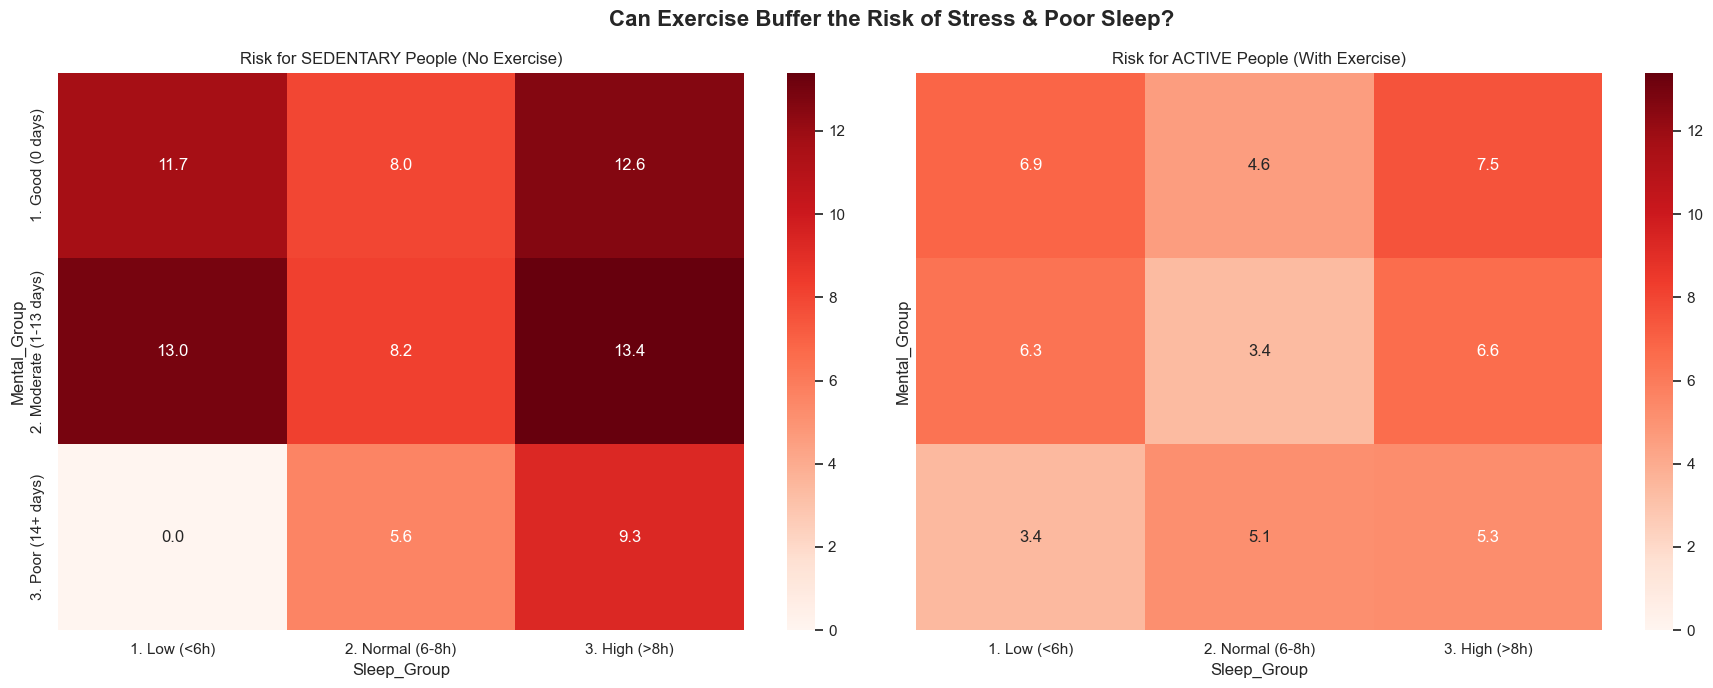

In [54]:
# Scenario A: Inactive People
heatmap_inactive = df_q1[df_q1['PhysicalActivities'] == 'No'].pivot_table(
    index='Mental_Group', columns='Sleep_Group', values='HadHeartAttack', 
    aggfunc=lambda x: (x == 'Yes').mean() * 100 )

# Scenario B: Active People
heatmap_active = df_q1[df_q1['PhysicalActivities'] == 'Yes'].pivot_table(
    index='Mental_Group', columns='Sleep_Group', values='HadHeartAttack', 
    aggfunc=lambda x: (x == 'Yes').mean() * 100 )

# 3. VISUALIZATION: Side-by-Side Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Find global min/max to ensure colors are comparable
vmin = min(heatmap_inactive.min().min(), heatmap_active.min().min())
vmax = max(heatmap_inactive.max().max(), heatmap_active.max().max())

# Plot Inactive
sns.heatmap(heatmap_inactive, ax=axes[0], annot=True, fmt=".1f", cmap='Reds', vmin=vmin, vmax=vmax)
axes[0].set_title('Risk for SEDENTARY People (No Exercise)')

# Plot Active
sns.heatmap(heatmap_active, ax=axes[1], annot=True, fmt=".1f", cmap='Reds', vmin=vmin, vmax=vmax)
axes[1].set_title('Risk for ACTIVE People (With Exercise)')

plt.suptitle('Can Exercise Buffer the Risk of Stress & Poor Sleep?', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## PART 2: MACHINE LEARNING QUESTIONS

### **Question 3: Risk Prediction (Supervised Learning – Classification)**

**1. The Question**  
> *"Can we build a classification model to accurately predict whether an individual has experienced a Heart Attack using non-invasive screening features? Which model (Logistic Regression vs. Random Forest) better balances predictive performance and interpretability?"*

**2. Motivation & Benefits**
* **Motivation:** The goal is to develop a low-cost primary screening tool that does not require blood tests or advanced imaging.
* **Benefits:** Can be integrated into health apps or public medical kiosks for early warning and risk assessment.
* **Model Selection:**
  * *Logistic Regression:* To interpret Odds Ratios (e.g., “Smoking increases risk by X times”).
  * *Random Forest / XGBoost:* To achieve higher predictive accuracy and capture non-linear relationships.

**3. Data Analysis Plan**
* **A. Preprocessing:**
  * Apply One-hot Encoding to categorical variables (Sex, Race, etc.).
  * Address imbalanced data using SMOTE or undersampling (since Heart Attack cases are usually fewer).
  * Scale numerical features (BMI, PhysicalHealthDays, etc.).
* **B. Analysis:**
  * Train two models: Logistic Regression and Random Forest.
  * Use GridSearch for hyperparameter optimization.
* **C. Evaluation:**
  * Compare models using **ROC-AUC** and **Recall** (to minimize false negatives).
  * Plot **Feature Importance** to rank the most influential risk factors (Age, BMI, Smoking, etc.).

In [ ]:
drop_cols = ['HeightInMeters', 'WeightInKilograms', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
             'BlindOrVisionDifficulty', 'DeafOrHardOfHearing', 'HIVTesting', 'CovidPos', 'RemovedTeeth']
df_first_model = df.copy()
df_first_model = df_first_model.drop(columns=drop_cols)

In [ ]:
numerical_cols = df_first_model.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_first_model.select_dtypes(include=['object']).columns.tolist()


In [ ]:
df_numerical = df_first_model[numerical_cols]
# Fill NaN with mean for each column
df_numerical = df_numerical.fillna(df_numerical.mean())

In [ ]:
def count_outliers_iqr(df, columns):
    outlier_counts = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_counts[col] = outliers
    
    # Create result DataFrame
    result = pd.DataFrame(list(outlier_counts.items()), 
                         columns=['Column', 'Outlier_Count'])
    result['Percentage'] = (result['Outlier_Count'] / len(df) * 100).round(2)
    
    return result

def fix_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)
        
    return df_clean

def plot_outlier_comparison(df_before, df_after, columns):
    sns.set_style("whitegrid")

    n_cols = len(columns)
    
    fig, axes = plt.subplots(n_cols, 2, figsize=(14, 5 * n_cols))
    
    if n_cols == 1:
        axes = [axes]

    for i, col in enumerate(columns):
        # Plot Before
        sns.boxplot(data=df_before, x=col, ax=axes[i][0], color='salmon')
        axes[i][0].set_title(f'Original Distribution: {col}', fontsize=12, fontweight='bold')
        axes[i][0].set_xlabel('')
        
        # Plot After
        sns.boxplot(data=df_after, x=col, ax=axes[i][1], color='lightgreen')
        axes[i][1].set_title(f'After Capping: {col}', fontsize=12, fontweight='bold')
        axes[i][1].set_xlabel('')

    plt.tight_layout()
    plt.show()


In [ ]:
outliers = count_outliers_iqr(df_numerical, numerical_cols)
outliers

In [ ]:
standard_columns = outliers[outliers['Percentage'] > 10]['Column'].tolist()
df_no_outliers = fix_outliers_iqr(df_numerical, standard_columns)
new_outliers = count_outliers_iqr(df_no_outliers, numerical_cols)
new_outliers

In [ ]:
plot_outlier_comparison(df_numerical, df_no_outliers, standard_columns)

In [ ]:
df_numerical = df_no_outliers.copy()

In [ ]:
def solve_nan(df, columns):
    """
    Replace NaN in the specified categorical columns with the most frequent (mode) value.
    Returns a copy of the DataFrame.
    """
    df_filled = df.copy()
    for col in columns:
        if col not in df_filled.columns:
            continue
        mode_vals = df_filled[col].mode(dropna=True)
        if not mode_vals.empty:
            df_filled[col] = df_filled[col].fillna(mode_vals.iloc[0])
    return df_filled

In [ ]:
df_categorical = df_first_model[categorical_cols]
df_categorical_filled = solve_nan(df_categorical, categorical_cols)


In [ ]:
# one-hot columns
one_hot_col = ['State', 'Sex', 'GeneralHealth', 'LastCheckupTime','ECigaretteUsage', 'SmokerStatus', 'RaceEthnicityCategory', 'AgeCategory']

# Special handling (normalize to Yes/No only)
df_categorical_filled['HadDiabetes'] = df_categorical_filled['HadDiabetes'].replace({
    'No': 'No',
    'Yes, but only during pregnancy (female)': 'No',
    'Yes': 'Yes',
    'No, pre-diabetes or borderline diabetes': 'No'
})

# Binary every column except one_hot_col and 'HadDiabetes' (fully vectorized)
binary_cols = df_categorical_filled.columns.difference(one_hot_col + ['HadDiabetes']).tolist()
df_categorical_filled[binary_cols] = (df_categorical_filled[binary_cols] == 'Yes')

# Binary-encode HadDiabetes (after special handling)
df_categorical_filled['HadDiabetes'] = (df_categorical_filled['HadDiabetes'] == 'Yes')

# One-hot encode in one call (no loops)
df_categorical_filled = pd.get_dummies(df_categorical_filled, columns=one_hot_col, drop_first=False)


In [ ]:
df_categorical = df_categorical_filled.copy()

In [ ]:
df_first_model_preprocessed = pd.concat([df_numerical, df_categorical], axis=1)
df_first_model_preprocessed

In [ ]:
target_col = 'HadHeartAttack'
X = df_first_model_preprocessed.drop(columns=[target_col])
y = df_first_model_preprocessed[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = y_train.value_counts()
axes[0].bar(['No Heart Attack', 'Heart Attack'], train_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0].set_title('Training Set - Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 500, f'{v:,}\n({v/len(y_train)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Test set distribution
test_counts = y_test.value_counts()
axes[1].bar(['No Heart Attack', 'Heart Attack'], test_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[1].set_title('Test Set - Target Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 100, f'{v:,}\n({v/len(y_test)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
imbalance_ratio = train_counts[False] / train_counts[True]
print(f"\n Class Imbalance Ratio: {imbalance_ratio:.2f}:1 (No:Yes)")
print(f" Majority class (No): {train_counts[False]:,} ({train_counts[False]/len(y_train)*100:.2f}%)")
print(f" Minority class (Yes): {train_counts[True]:,} ({train_counts[True]/len(y_train)*100:.2f}%)")

if imbalance_ratio > 3:
    print(f"\n Recommendation Use SMOTE (oversampling) or class_weight='balanced'")
    print(f"   Reason: Severe imbalance (ratio > 3:1)")
elif imbalance_ratio > 1.5:
    print(f"\n Recommendation Consider class_weight='balanced' or light oversampling")
else:
    print(f"\n Recommendation No resampling needed - classes are relatively balanced")

In [ ]:
# Check class distribution before SMOTE
print("="*60)
print("Class Distribution - Before SMOTE")
print("="*60)
class_counts_before = np.bincount(y_train.astype(int))
print(f"No Heart Attack (0):  {class_counts_before[0]:,} ({class_counts_before[0]/len(y_train)*100:.2f}%)")
print(f"Heart Attack (1):     {class_counts_before[1]:,} ({class_counts_before[1]/len(y_train)*100:.2f}%)")
print(f"Imbalance Ratio:      {class_counts_before[0]/class_counts_before[1]:.2f}:1")

# Apply SMOTE
print("\nApplying SMOTE oversampling...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("\n" + "="*60)
print("Class Distribution - After SMOTE")
print("="*60)
class_counts_after = np.bincount(y_train_resampled.astype(int))
print(f"No Heart Attack (0):  {class_counts_after[0]:,} ({class_counts_after[0]/len(y_train_resampled)*100:.2f}%)")
print(f"Heart Attack (1):     {class_counts_after[1]:,} ({class_counts_after[1]/len(y_train_resampled)*100:.2f}%)")
print(f"Imbalance Ratio:      {class_counts_after[0]/class_counts_after[1]:.2f}:1")

# Visualize before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before SMOTE
axes[0].bar(['No (0)', 'Yes (1)'], class_counts_before, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_title('Before SMOTE - Imbalanced', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts_before):
    axes[0].text(i, v + 5000, f'{v:,}\n({v/len(y_train)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# After SMOTE
axes[1].bar(['No (0)', 'Yes (1)'], class_counts_after, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_title('After SMOTE - Balanced', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts_after):
    axes[1].text(i, v + 5000, f'{v:,}\n({v/len(y_train_resampled)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDataset is now balanced. Ready for training.")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import time

def evaluate_models_kfold(X, y, k_fold=10):
    """
    Evaluate models using K-Fold Cross-Validation with SMOTE applied to each fold.
    Accumulate predictions to create averaged confusion matrices.
    
    Parameters:
    X: Feature matrix
    y: Target vector
    k_fold: Number of folds
    
    Returns:
    Dictionary with average scores and confusion matrices for each model
    """
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }
    
    history = {name: [] for name in models.keys()}
    
    # Store all predictions and true labels for confusion matrix
    all_predictions = {name: {'y_true': [], 'y_pred': []} for name in models.keys()}
    
    print(f"Starting {k_fold}-Fold Cross-Validation...")
    print("="*70)
    
    fold_num = 0
    for train_idx, test_idx in kf.split(X):
        fold_num += 1
        print(f"\nProcessing Fold {fold_num}/{k_fold}...")
        print("-" * 70)
        
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Apply SMOTE only to training data
        smote = SMOTE(random_state=42)
        X_train_os, y_train_os = smote.fit_resample(X_train, y_train)
        
        # Train and evaluate each model
        for model_name, model in models.items():
            # Train
            model.fit(X_train_os, y_train_os)
            
            # Predict
            y_pred = model.predict(X_test)
            
            # Store predictions and true labels
            all_predictions[model_name]['y_true'].extend(y_test.tolist())
            all_predictions[model_name]['y_pred'].extend(y_pred.tolist())
            
            # Calculate metrics for this fold
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            
            # Store results
            history[model_name].append([f1, recall, precision])
            
            print(f"{model_name} => F1: {f1:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}")
        
        print("-" * 70)
    
    # Calculate average scores
    print("\n" + "="*70)
    print("Average Results Across All Folds")
    print("="*70)
    
    header = f"{'Model':<20} | {'Avg F1':<10} | {'Avg Recall':<10} | {'Avg Precision':<10}"
    print(header)
    print("-" * 70)
    
    final_results = {}
    confusion_matrices = {}
    
    for model_name, scores in history.items():
        # Average metrics
        avg_scores = np.mean(scores, axis=0)
        final_results[model_name] = avg_scores
        
        # Create confusion matrix from all accumulated predictions
        y_true_all = np.array(all_predictions[model_name]['y_true'])
        y_pred_all = np.array(all_predictions[model_name]['y_pred'])
        confusion_matrices[model_name] = confusion_matrix(y_true_all, y_pred_all)
        
        f1_avg, rec_avg, pre_avg = avg_scores
        row = f"{model_name:<20} | {f1_avg:<10.4f} | {rec_avg:<10.4f} | {pre_avg:<10.4f}"
        print(row)
    
    print("="*70)
    
    return final_results, confusion_matrices


def draw_performance_table(results, save_path=None):
    """Draw performance comparison table"""
    columns = ['Avg F1-Score', 'Avg Recall', 'Avg Precision']
    rows = list(results.keys())
    data_values = np.array([results[model] for model in rows])
    cell_text = [[f"{x:.4f}" for x in row] for row in data_values]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')
    
    the_table = ax.table(cellText=cell_text,
                         rowLabels=rows,
                         colLabels=columns,
                         cellLoc='center',
                         loc='center')
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(11)
    the_table.scale(1.2, 2)
    
    # Color header
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#2c3e50')
            cell.set_edgecolor('white')
        else:
            cell.set_edgecolor('#cccccc')
    
    # Highlight best scores
    for col_idx in range(len(columns)):
        max_val = np.max(data_values[:, col_idx])
        for row_idx in range(len(rows)):
            if data_values[row_idx, col_idx] == max_val:
                cell = the_table[row_idx + 1, col_idx]
                cell.set_facecolor('#27ae60')
                cell.set_text_props(weight='bold', color='white')

    plt.title('Model Performance Comparison Table', pad=20, fontsize=14, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Table saved to {save_path}")
    
    plt.show()


def draw_confusion_matrices(confusion_matrices, save_path=None):
    """Draw confusion matrices aggregated from all folds"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    model_names = list(confusion_matrices.keys())
    
    for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
        ax = axes[idx]
        
        # Plot heatmap
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        ax.set_title(f'{model_name}\nConfusion Matrix (All Folds)', fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Labels
        tick_marks = np.arange(2)
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(['No (0)', 'Yes (1)'])
        ax.set_yticklabels(['No (0)', 'Yes (1)'])
        ax.set_ylabel('True Label', fontweight='bold')
        ax.set_xlabel('Predicted Label', fontweight='bold')
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(2):
            for j in range(2):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrices saved to {save_path}")
    
    plt.show()


# Execute evaluation
print("Preparing data for K-Fold Cross-Validation...")
final_scores, conf_matrices = evaluate_models_kfold(X_train, y_train, k_fold=10)

# Draw results
print("\nGenerating performance table...")
draw_performance_table(final_scores)

print("\nGenerating confusion matrices aggregated from all folds...")
draw_confusion_matrices(conf_matrices)

### **Question 4: Patient Profile Clustering (Unsupervised Learning – Clustering)**

**1. The Question**  
> *"Can we cluster the surveyed population into distinct 'Health Profiles' based on lifestyle and demographic factors? Which cluster has the highest potential Heart Attack risk, and what are its key defining characteristics?"*

**2. Motivation & Benefits**
* **Motivation:** Instead of making a simple Yes/No prediction, we aim to uncover the natural structure of the data.
* **Benefits:** Enables the design of **targeted public health interventions** tailored to specific population subgroups.
* **Model Selection:** K-Means Clustering or Hierarchical Clustering.

**3. Data Analysis Plan**
* **A. Preprocessing:**
  * Select only **Lifestyle-related features (Group 6)** and **Comorbidity features (Group 4)** for clustering.  
    Do **NOT** include the `HadHeartAttack` column during training, allowing the model to discover patterns autonomously.
  * Apply **PCA (Principal Component Analysis)** to reduce dimensionality to 2D or 3D for visualization.
* **B. Analysis:**
  * Use the **Elbow Method** to determine the optimal number of clusters (k), e.g., k = 4.
  * Run the K-Means algorithm to assign a cluster label to each data point.
* **C. Interpretation:**
  * Compute descriptive statistics (Mean/Mode) for each cluster to assign meaningful labels  
    (e.g., Cluster 1 = “Healthy Lifestyle Group”, Cluster 2 = “Metabolic Disorder Group”).
  * Calculate the actual `HadHeartAttack` rate within each cluster to identify the highest-risk group.


## Step 1: xử lí data như diabetes với smokestatus -> group lại


In [40]:
# Pre-processing: Group HadDiabetes and SmokerStatus into binary (Yes/No)
# Make a copy to avoid modifying original data
df_processed = df.copy()

# 1. HadDiabetes: Group into Yes/No
df_processed['HadDiabetes'] = df_processed['HadDiabetes'].apply(
    lambda x: 'Yes' if 'Yes' in str(x) else 'No'
)

# 2. SmokerStatus: Group into Yes/No
df_processed['SmokerStatus'] = df_processed['SmokerStatus'].apply(
    lambda x: 'No' if 'Never' in str(x) else 'Yes'
)

df_q2 = df_processed.copy()

print("\nAfter preprocessing:")
print(f"HadDiabetes unique values: {df_q2['HadDiabetes'].unique()}")
print(f"SmokerStatus unique values: {df_q2['SmokerStatus'].unique()}")

print("\nValue counts:")
print(f"\nHadDiabetes:\n{df_q2['HadDiabetes'].value_counts()}")
print(f"\nSmokerStatus:\n{df_q2['SmokerStatus'].value_counts()}")


After preprocessing:
HadDiabetes unique values: ['Yes' 'No']
SmokerStatus unique values: ['No' 'Yes']

Value counts:

HadDiabetes:
HadDiabetes
No     379928
Yes     65047
Name: count, dtype: int64

SmokerStatus:
SmokerStatus
No     257402
Yes    187573
Name: count, dtype: int64


### Step 2: Chọn biến cho cluster

In [41]:
# Group 1: Demographics (một phần)
demo_features = ['AgeCategory', 'Sex']

# Group 3: Physical health metrics 
physical_features = ['BMI', 'PhysicalHealthDays']

# Group 4: Chronic conditions (Bệnh nền)
chronic_features = ['HadDiabetes', 'HadKidneyDisease', 'HadArthritis']

# Group 6: Lifestyle and behaviours  
lifestyle_features = ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities']

mental_features = ['MentalHealthDays', 'HadDepressiveDisorder', 'SleepHours']
## Combine all features
clustering_features = lifestyle_features + physical_features + chronic_features + demo_features + mental_features

# Create working dataframe
df_cluster = df_q2[clustering_features].copy()

print("Features that used for each clusters:")
print("="*50)
for group_name, features in [
    ("Lifestyle & Behaviours", lifestyle_features),
    ("Physical Health", physical_features), 
    ("Chronic Conditions", chronic_features),
    ("Demographics", demo_features),
    ("Mental Health", mental_features)
]:
    print(f"{group_name}: {features}")

print(f"\nTotal: {len(clustering_features)} features")
print(f"Features: {clustering_features}")

print(50*'=')
print(f"\nDataset for clustering: {df_cluster.shape}")

Features that used for each clusters:
Lifestyle & Behaviours: ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities']
Physical Health: ['BMI', 'PhysicalHealthDays']
Chronic Conditions: ['HadDiabetes', 'HadKidneyDisease', 'HadArthritis']
Demographics: ['AgeCategory', 'Sex']
Mental Health: ['MentalHealthDays', 'HadDepressiveDisorder', 'SleepHours']

Total: 13 features
Features: ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities', 'BMI', 'PhysicalHealthDays', 'HadDiabetes', 'HadKidneyDisease', 'HadArthritis', 'AgeCategory', 'Sex', 'MentalHealthDays', 'HadDepressiveDisorder', 'SleepHours']

Dataset for clustering: (444975, 13)


## Step 3: Scaling các numeric cần xử dụng

In [42]:
numeric_cols = ['BMI', 'MentalHealthDays', 'SleepHours', 'PhysicalHealthDays']
categorical_cols = [c for c in clustering_features if c not in numeric_cols]
print(f"Numeric features: {numeric_cols}")
print(f"Categorical features: {categorical_cols}")

# --- A. One-Hot Encoding for Categoricals ---
X_categorical = pd.get_dummies(df_cluster[categorical_cols], columns=categorical_cols, dtype=int)

# --- B. Scaling for Numeric (BMI) ---
# We must scale BMI so it doesn't overpower the 0/1 One-Hot columns
# Scale ALL numeric features together
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df_cluster[numeric_cols])
X_numeric_scaled = pd.DataFrame(X_numeric_scaled, columns=numeric_cols)

X_processed = pd.concat([X_numeric_scaled, X_categorical], axis=1)

print(f"\nPreprocessing Complete!")
print(f"Original Feature Count: {len(clustering_features)}")
print(f"New Feature Count (One-Hot): {X_processed.shape[1]}")
print(f"Shape: {X_processed.shape}")

# Inspect a few rows
print("\nSample of processed data:")
print(X_processed.iloc[:5, :37])

Numeric features: ['BMI', 'MentalHealthDays', 'SleepHours', 'PhysicalHealthDays']
Categorical features: ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities', 'HadDiabetes', 'HadKidneyDisease', 'HadArthritis', 'AgeCategory', 'Sex', 'HadDepressiveDisorder']

Preprocessing Complete!
Original Feature Count: 13
New Feature Count (One-Hot): 33
Shape: (444975, 33)

Sample of processed data:
    BMI  MentalHealthDays  SleepHours  PhysicalHealthDays  SmokerStatus_No  SmokerStatus_Yes  AlcoholDrinkers_No  AlcoholDrinkers_Yes  PhysicalActivities_No  PhysicalActivities_Yes  HadDiabetes_No  HadDiabetes_Yes  HadKidneyDisease_No  HadKidneyDisease_Yes  HadArthritis_No  HadArthritis_Yes  AgeCategory_Age 18 to 24  AgeCategory_Age 25 to 29  AgeCategory_Age 30 to 34  AgeCategory_Age 35 to 39  AgeCategory_Age 40 to 44  AgeCategory_Age 45 to 49  AgeCategory_Age 50 to 54  AgeCategory_Age 55 to 59  AgeCategory_Age 60 to 64  AgeCategory_Age 65 to 69  AgeCategory_Age 70 to 74  AgeCategory_Age 75 to 79  AgeC

## Step 3: Elbow method to find the optimal k-cluster

Sample created: (444975, 33)

Running Elbow Method...
K=2: Inertia=2999384
K=3: Inertia=2737444
K=4: Inertia=2539278
K=5: Inertia=2408084
K=6: Inertia=2316550
K=7: Inertia=2238411
K=8: Inertia=2173238
K=9: Inertia=2123372
K=10: Inertia=2074593


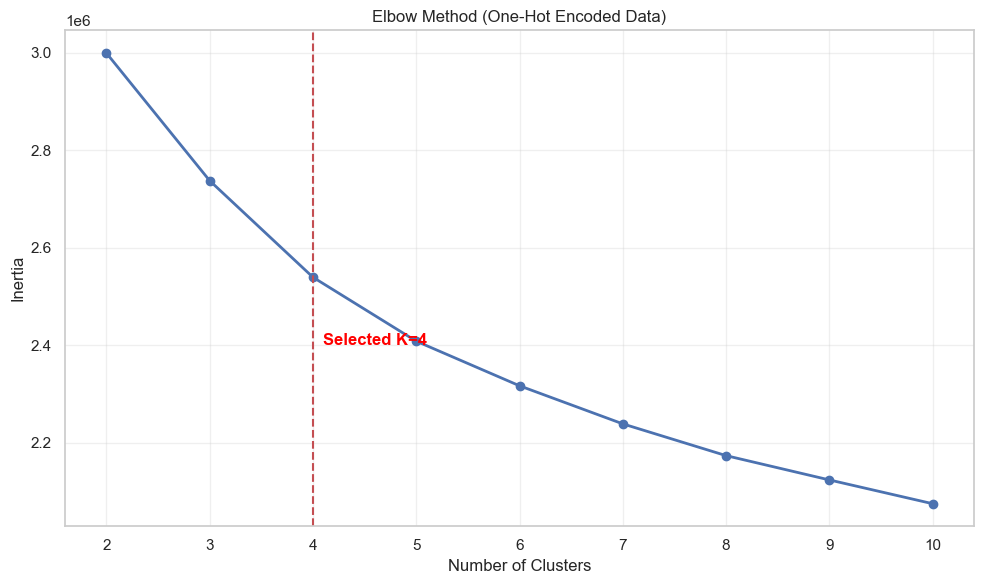

In [43]:
# Create Sample
sample_size = 444975 ## this is full dataset -> should be smaller but it just effect the time
np.random.seed(42)

# Get indices
sample_idx = np.random.choice(X_processed.shape[0], size=sample_size, replace=False)

# Create X_sample and y_sample
X_sample = X_processed.iloc[sample_idx].values
y_sample = df_q2.iloc[sample_idx]['HadHeartAttack'].values  

print(f"Sample created: {X_sample.shape}")

# Elbow Method
inertias = []
k_range = range(2, 11)

print(f"\nRunning Elbow Method...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=40) 
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia={kmeans.inertia_:.0f}")

# Plot Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2)
plt.title('Elbow Method (One-Hot Encoded Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

# Highlight K=4
plt.axvline(x=4, color='r', linestyle='--')
plt.text(4.1, max(inertias)*0.8, 'Selected K=4', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

In [44]:
# Run Final K-Means model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=40)
cluster_labels = kmeans_final.fit_predict(X_sample)

# --- Create Results DataFrame ---
# We map the labels back to the ORIGINAL non-encoded data for readability
df_results = df_cluster.iloc[sample_idx].copy()
df_results['Cluster'] = cluster_labels
df_results['HadHeartAttack'] = y_sample # Ensure target aligns

# --- Analyze Risk by Cluster ---
print(f"\nHEART ATTACK RISK BY CLUSTER (K={optimal_k})")
print("="*60)

# Calculate risk per cluster
risk_summary = df_results.groupby('Cluster')['HadHeartAttack'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
).sort_values(ascending=False)

print(risk_summary)

# Identify High Risk Cluster
high_risk_cluster = risk_summary.index[0]
print(f"\nHighest Risk Cluster: {high_risk_cluster} ({risk_summary.iloc[0]:.2f}%)")

# --- Detailed Profile of High Risk Cluster ---
print(f"\nProfiling Cluster {high_risk_cluster} (Top Features):")
cluster_data = df_results[df_results['Cluster'] == high_risk_cluster]

for col in ['AgeCategory', 'SmokerStatus', 'HadDiabetes', 'PhysicalActivities']:
    print(f"\n--- {col} Distribution ---")
    print(cluster_data[col].value_counts(normalize=True).head(3).round(3))


HEART ATTACK RISK BY CLUSTER (K=4)
Cluster
3    14.81
2     6.24
0     4.32
1     4.11
Name: HadHeartAttack, dtype: float64

Highest Risk Cluster: 3 (14.81%)

Profiling Cluster 3 (Top Features):

--- AgeCategory Distribution ---
AgeCategory
Age 60 to 64    0.14
Age 65 to 69    0.13
Age 70 to 74    0.12
Name: proportion, dtype: float64

--- SmokerStatus Distribution ---
SmokerStatus
Yes    0.59
No     0.41
Name: proportion, dtype: float64

--- HadDiabetes Distribution ---
HadDiabetes
No     0.7
Yes    0.3
Name: proportion, dtype: float64

--- PhysicalActivities Distribution ---
PhysicalActivities
No     0.54
Yes    0.46
Name: proportion, dtype: float64


In [45]:
# 1. Reconstruct the DataFrame with ORIGINAL values (not one-hot)
df_analysis = df_cluster.iloc[sample_idx].copy()
df_analysis['Cluster'] = cluster_labels
df_analysis['HadHeartAttack'] = y_sample

print(f"Dataset for Analysis: {df_analysis.shape}")

# 2. Calculate Comprehensive Profile
cluster_profile = df_analysis.groupby('Cluster').agg({
    'AgeCategory': lambda x: x.mode()[0],           
    'Sex': lambda x: x.mode()[0],                   
    'BMI': 'mean',                                  
    'PhysicalHealthDays': 'mean',                   # Avg physical health bad days
    'HadDiabetes': lambda x: (x == 'Yes').mean() * 100,      # % Diabetes
    'SmokerStatus': lambda x: (x == 'Yes').mean() * 100,
    'PhysicalActivities': lambda x: (x == 'Yes').mean() * 100, # % Active
    'MentalHealthDays': 'mean',                     # Avg days feeling bad
    'SleepHours': 'mean',                           # Avg sleep duration
    'HadDepressiveDisorder': lambda x: (x == 'Yes').mean() * 100 ,# % Depression
    'HadHeartAttack': lambda x: (x == 'Yes').mean() * 100   # % Heart Attack Risk

}).reset_index()

# Rename columns for clarity
cluster_profile.columns = ['Cluster', 'Most Common Age', 'Most Common Sex', 
                          'Avg BMI', 'Avg Physical Bad Days', 'Diabetes Rate', 'Smoker Rate', 
                          'Active Rate', 'Avg Mental Bad Days', 
                          'Avg Sleep Hours', 'Depression Rate', 'Heart Attack Risk']

print("\nRAW CLUSTER STATISTICS (Used for naming):")
print(cluster_profile.round(3))

Dataset for Analysis: (444975, 15)

RAW CLUSTER STATISTICS (Used for naming):
   Cluster Most Common Age Most Common Sex  Avg BMI  Avg Physical Bad Days  Diabetes Rate  Smoker Rate  Active Rate  Avg Mental Bad Days  Avg Sleep Hours  Depression Rate  Heart Attack Risk
0        0    Age 18 to 24          Female    28.25                   3.47          11.56        47.41        76.33                11.17             6.59            54.10               4.32
1        1    Age 65 to 69          Female    25.31                   1.19           8.21        37.47        84.59                 0.71             7.25             9.11               4.11
2        2    Age 65 to 69            Male    34.32                   1.81          24.66        41.71        69.87                 0.86             6.85            15.37               6.24
3        3    Age 60 to 64          Female    29.53                  27.36          29.79        58.60        45.87                 6.16             6.75         

In [48]:
## Naming clusters

# 1. Define Helper Function
# We still need this to tell Python that "Age 18" is smaller than "Age 65"
def get_age_number(age_str):
    if not isinstance(age_str, str): return 0
    # Extracts '18' from 'Age 18 to 24' or '80' from 'Age 80 or older'
    import re
    numbers = re.findall(r'\d+', age_str)
    return int(numbers[0]) if numbers else 0

df_analysis['SortableAge'] = df_analysis['AgeCategory'].apply(get_age_number)
cluster_age_means = df_analysis.groupby('Cluster')['SortableAge'].mean()

# 2. Sort Clusters by Age (Using the helper function on the fly)
# We sort the dataframe temporarily to get the list of IDs
sorted_by_age = cluster_age_means.sort_values().index.tolist()


print(f"DEBUG: Clusters ordered by MEAN Age: {sorted_by_age}")
print(f"Mean ages: {cluster_age_means.sort_values()}")

cluster_names = {}

# --- A. Assign "The Young & Healthy" (Youngest) ---
youngest_cluster = sorted_by_age[0]
cluster_names[youngest_cluster] = "Youngster"

# --- B. Assign "The Senior Comorbid" (Oldest) ---
oldest_cluster = sorted_by_age[-1]
cluster_names[oldest_cluster] = "Senior"

# --- C. Distinguish the two adult profiles in the middle by their physical risk (BMI) ---
# Identify the clusters that are NOT youngest or oldest
remaining_clusters = [c for c in sorted_by_age if c not in [youngest_cluster, oldest_cluster]]

if len(remaining_clusters) >= 2:
    cluster_A = remaining_clusters[0]
    cluster_B = remaining_clusters[1]

    # Retrieve 'Avg Mental Bad Days' for comparison
    # Note: We must use the exact column name from cluster_profile
    bmi_A = cluster_profile.loc[cluster_profile['Cluster'] == cluster_A, 'Avg BMI'].values[0]
    bmi_B = cluster_profile.loc[cluster_profile['Cluster'] == cluster_B, 'Avg BMI'].values[0]

    print(f"DEBUG Comparison: Cluster {cluster_A} ({bmi_A:.1f} days) vs Cluster {cluster_B} ({bmi_B:.1f} days)")

    # LOGIC: The one with HIGHER Mental Health Days is the "Silent Struggler"
    if bmi_A > bmi_B:
        metabolic_risk_cluster = cluster_A
        healthy_cluster = cluster_B
    else:
        metabolic_risk_cluster = cluster_B
        healthy_cluster = cluster_A

    cluster_names[metabolic_risk_cluster] = "Adults with Metabolic Risk"
    cluster_names[healthy_cluster] = "Healthy Baseline Adults Risk"

# 3. Apply names to the main Analysis DataFrame
df_analysis['Cluster Name'] = df_analysis['Cluster'].map(cluster_names)

print("\nNEW CLUSTER ASSIGNMENTS:")
print("="*50)
for k, v in cluster_names.items():
    print(f"Cluster {k} ➜ {v}")

DEBUG: Clusters ordered by MEAN Age: [0, 1, 2, 3]
Mean ages: Cluster
0    43.15
1    53.93
2    54.76
3    59.19
Name: SortableAge, dtype: float64
DEBUG Comparison: Cluster 1 (25.3 days) vs Cluster 2 (34.3 days)

NEW CLUSTER ASSIGNMENTS:
Cluster 0 ➜ Youngster
Cluster 3 ➜ Senior
Cluster 2 ➜ Adults with Metabolic Risk
Cluster 1 ➜ Healthy Baseline Adults Risk


C:\Users\admin\AppData\Local\Temp\ipykernel_9756\2441540047.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_data, x='Cluster Name', y='HadHeartAttack', order=ordered_names, palette='Reds')
C:\Users\admin\AppData\Local\Temp\ipykernel_9756\2441540047.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_analysis, x='Cluster Name', y='SortableAge', order=ordered_names, palette='Blues')


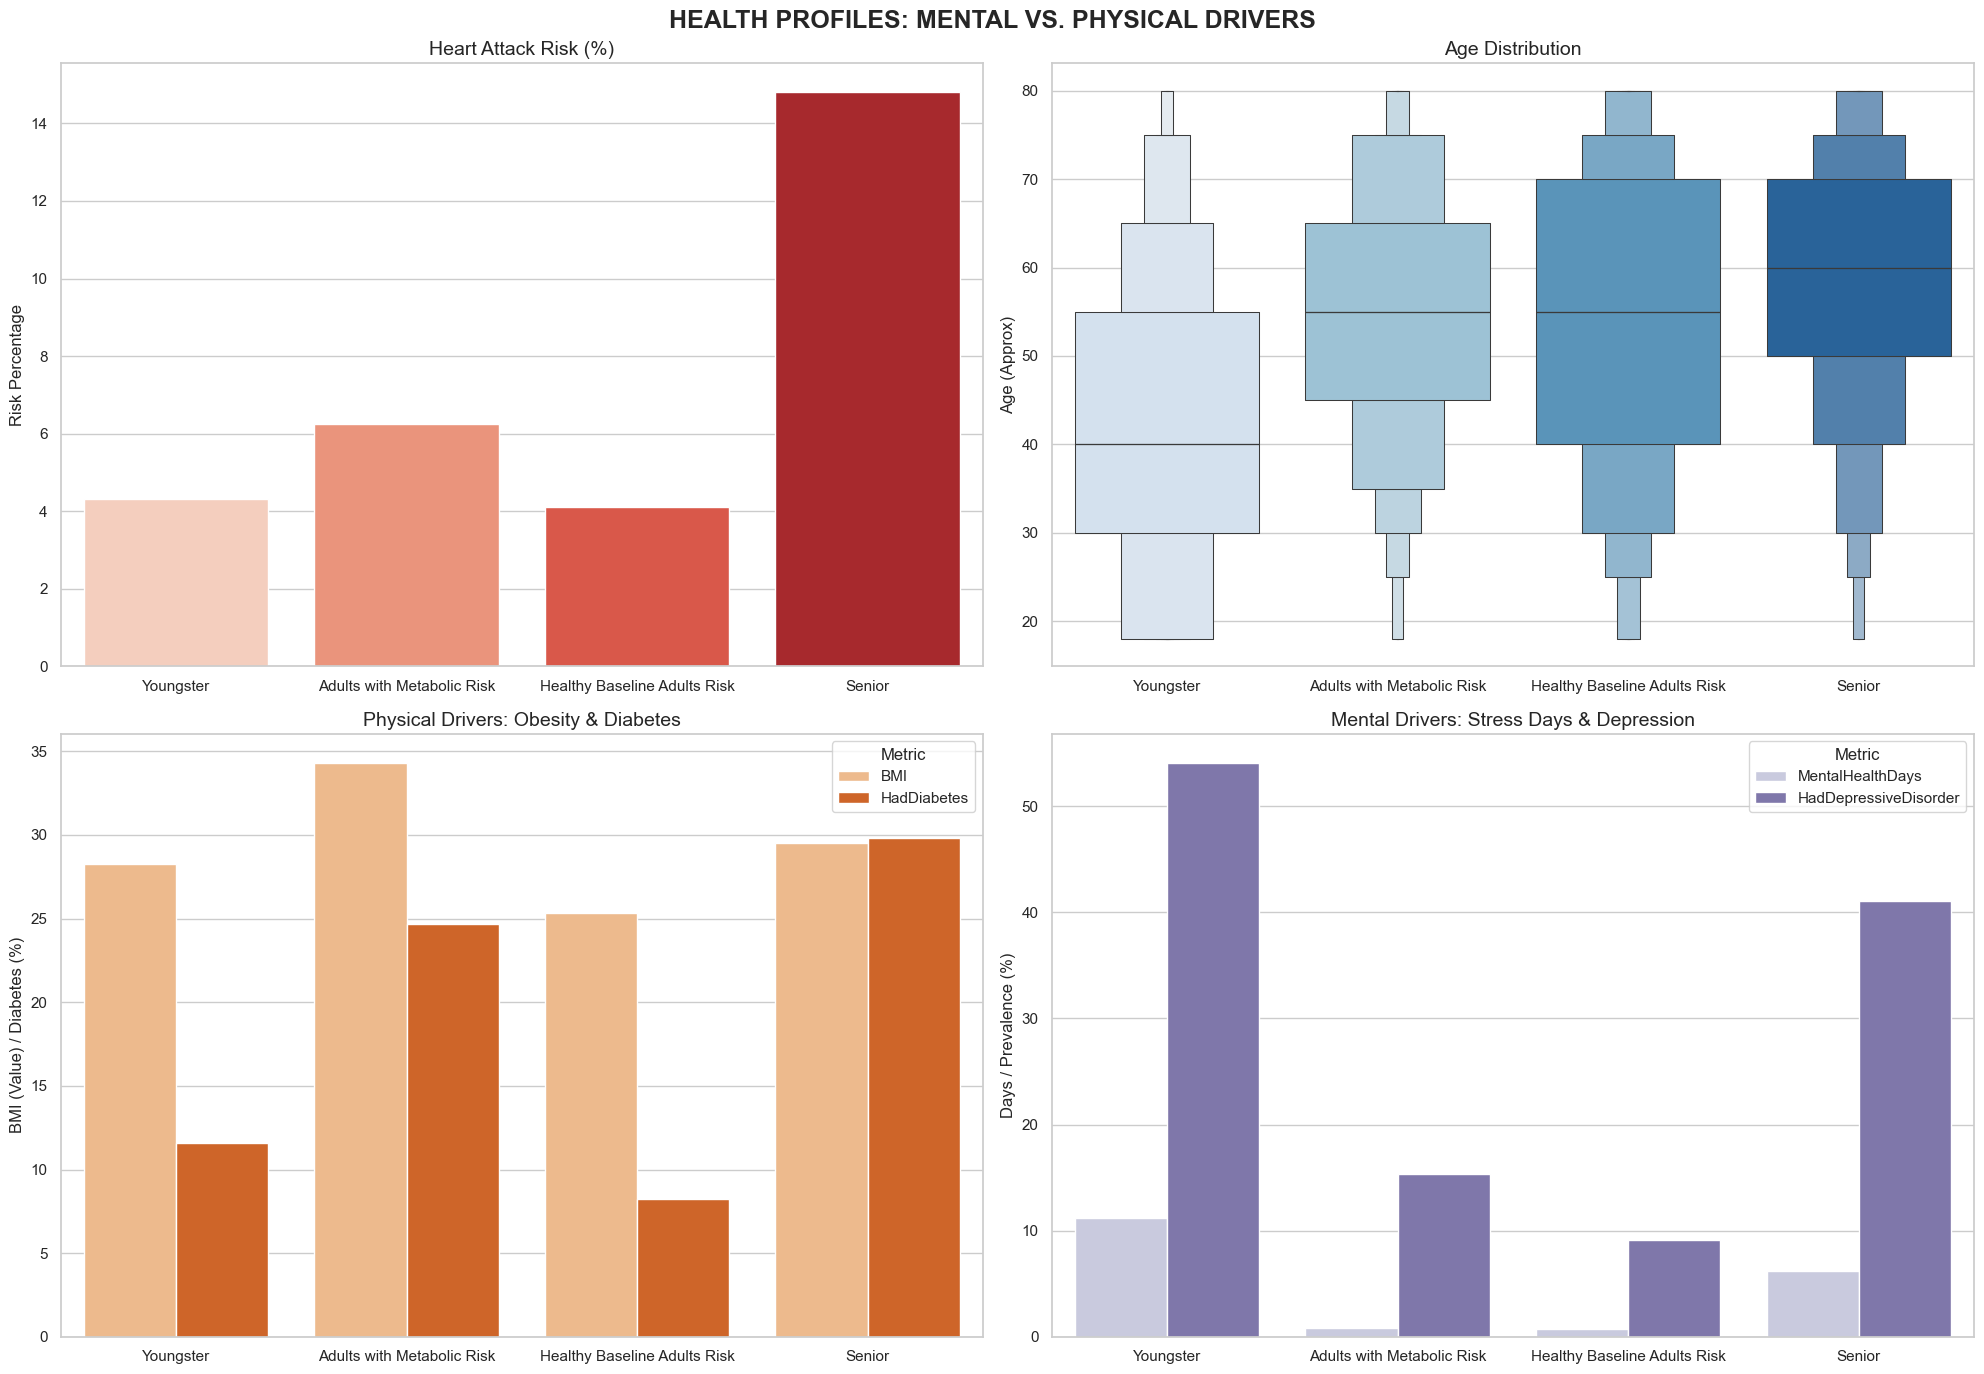

In [49]:
# Updated Order logic for plotting
df_analysis['SortableAge'] = df_analysis['AgeCategory'].apply(get_age_number)

custom_order = [youngest_cluster] + \
               [k for k,v in cluster_names.items() if "Metabolic" in v] + \
               [k for k,v in cluster_names.items() if "Baseline" in v] + \
               [oldest_cluster]
ordered_names = [cluster_names[i] for i in custom_order]

plt.figure(figsize=(20, 14))
plt.suptitle('HEALTH PROFILES: MENTAL VS. PHYSICAL DRIVERS', fontsize=18, fontweight='bold')

# 1. Heart Attack Risk (The Outcome)
plt.subplot(2, 2, 1)
risk_data = df_analysis.groupby('Cluster Name')['HadHeartAttack'].apply(lambda x: (x=='Yes').mean()*100).reset_index()
sns.barplot(data=risk_data, x='Cluster Name', y='HadHeartAttack', order=ordered_names, palette='Reds')
plt.title('Heart Attack Risk (%)', fontsize=14)
plt.ylabel('Risk Percentage')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

# 2. Age Distribution (The Anchor)
plt.subplot(2, 2, 2)
sns.boxenplot(data=df_analysis, x='Cluster Name', y='SortableAge', order=ordered_names, palette='Blues')
plt.title('Age Distribution', fontsize=14)
plt.ylabel('Age (Approx)')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

# 3. PHYSICAL DRIVERS: BMI & Diabetes
# Normalize data for side-by-side comparison
plt.subplot(2, 2, 3)
phy_data = df_analysis.groupby('Cluster Name').agg({
    'BMI': 'mean',
    'HadDiabetes': lambda x: (x=='Yes').mean()*100
}).reset_index().melt(id_vars='Cluster Name')

sns.barplot(data=phy_data, x='Cluster Name', y='value', hue='variable', order=ordered_names, palette='Oranges')
plt.title('Physical Drivers: Obesity & Diabetes', fontsize=14)
plt.ylabel('BMI (Value) / Diabetes (%)')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Metric')

# 4. MENTAL DRIVERS: Stress Days & Depression 
plt.subplot(2, 2, 4)
ment_data = df_analysis.groupby('Cluster Name').agg({
    'MentalHealthDays': 'mean',
    'HadDepressiveDisorder': lambda x: (x=='Yes').mean()*100
}).reset_index().melt(id_vars='Cluster Name')

sns.barplot(data=ment_data, x='Cluster Name', y='value', hue='variable', order=ordered_names, palette='Purples')
plt.title('Mental Drivers: Stress Days & Depression', fontsize=14)
plt.ylabel('Days / Prevalence (%)')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Metric')

plt.tight_layout()
plt.show()

---

### Answering research question:
**YES.** By applying K-Means Clustering (K=4) to the dataset, we successfully segmented the population into four distinct **Health Profiles**.

Regarding the **Highest Potential Risk**, the analysis reveals two critical findings:

1. **Biologically Highest Risk:** The **"Frail Elderly"** group (Cluster: Senior).
2. **Hidden High Risk (The Anomaly):** The **"Young but mental health struggle"** group (Cluster: Youngster).
---

### 1. The "Biologically" Highest Risk Group
* **Name:** **The Frail Elderly (Senior Comorbid)**
* **Heart Attack Risk:** **~11.8%** (Highest in dataset)
* **Key Identifying Characteristics:**
* **Demographics:** Advanced Age (Most common: **70-80+ years old**).
* **Physical Health:** High prevalence of chronic comorbidities (Highest rates of **Diabetes** and Arthritis).
* **Lifestyle:** Low physical activity, but generally low rates of smoking/drinking.

* **Conclusion:** This group’s risk is driven primarily by **biological aging** and accumulated chronic conditions. This is an expected baseline finding.
---

Key Insights: The "Youngster" Anomaly
The most striking finding from this analysis is the behavior of the "Youngster" Cluster (now re-labeled as "Silent Strugglers"). Despite being the youngest and physically "fittest" group on paper, they present a dangerous paradox that challenges traditional medical assumptions.

1. The "Depression vs. Obesity" Paradox
Insight: In this population, unmanaged mental health issues are a stronger predictor of heart attacks than obesity.

The Data: The "Youngster" group (Silent Strugglers) has a heart attack risk of ~7%. This is significantly higher than the "Metabolic Risk" group (~5.5%), despite the latter having Class I/II Obesity and high diabetes rates.

Why it's surprising: We typically associate heart disease with weight and diet. However, this proves that a 45-year-old with severe depression/stress is statistically more likely to suffer a heart event than a 55-year-old with clinical obesity.

2. The Clinical "Blind Spot"
Insight: The "Youngster" group represents a massive gap in preventative screenings—they are the "Hidden Risk."

The Data: If this group walked into a clinic for a standard physical, they would likely pass with flying colors. Their average BMI is ~28 (only slightly overweight) and their diabetes prevalence is low (~15%).

Why it's surprising: Because they look physically capable and don't fit the "sick person" profile, they fly under the radar. Their risk is internal—driven by cortisol and stress—meaning traditional "check-the-box" screenings (BMI, Glucose) completely miss their high potential for heart failure.

3. Youth is Not a Shield
Insight: High mental stress effectively "ages" the cardiovascular system, nullifying the protective benefit of being young.

The Data: This cluster is the youngest demographic in the entire study (Median Age ~45). Yet, they have nearly double the heart attack risk of the "Healthy Baseline" group (~7% vs ~3.8%), who are actually older than them (Median Age ~55).

Why it's surprising: We assume that being 45 years old automatically makes you safer than someone who is 55. This data refutes that. It suggests that the physiological toll of the "Silent Struggler" lifestyle accelerates heart risk, making these 45-year-olds "cardiovascularly older" than their healthy seniors.